In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import math

##### Volume constant

In [2]:
V = 10e-12
NA = 6.023e23
vna = V*NA*10e-9*10e-3
ivna = 1/vna

#### Parameters 

In [3]:
#Synthesis and degradation of Clb1 :

kClb1s = 0.002
kClb1sp = 0.2
kClb1spp = 0.1
kClb1d = 0.1
kClb1dp = 0.2
kClb1dpp = 0.02

#NOTE : Decreasing Clb1 intrinsic decay rate widens Clb3 duration

kClb3s = 0.002
kClb3sp = 0.5
kClb3d = 0.2
kClb3Cdc20d = 0.2

#Cdc20

kCdc20s = 0.2
kCdc20d = 0.1
kCdc20Clb1p = 0.1
kCdc20Clb3p = 0.1
kCdc20a = 0.1
JCdc20Clb3 = 0.1
JCdc20clb1 = 0.1
JCdc20 = 0.1
kClb1Cdc20d = 0.3
kClb3Cdc20d = 0.3

#Clb1 phosophorylation of Cdc20 weaker than Clb3

#Synthesis and degradation of Clb4 :

kClb4s = 0.2
kClb4sp = 0.1
kClb4d = 0.2
kClb4dp = 1
kClb4dpp = 0.02

#Activation and inactivation of SP :

kSPa = 2
kSPi = 2
JSP = 0.01

#Synthesis, degradation, activation, and inactivation of Cdc5 :

kCdc5s = 0.004
kCdc5sp = 0.03
kCdc5spp = 0.02
kCdc5d = 0.02
kCdc5dp = 0.06
kCdc5dpp = 0.002
kCdc5a = 0.1
kCdc5ap = 0.4
kCdc5app = 0.3
kCdc5i = 0.1

#Synthesis, degradation, activation, and inacti - vation of Ndd1 :

kNdd1s = 0.03
kNdd1d = 0.0001
kNdd1dp = 1
kNdd1dpp = 0.02
kNdd1a = 0.1
kNdd1ap = 0.2
kNdd1app = 0.04
kNdd1i = 0.2
JNdd1 = 0.04

#Degradation of Hcm1 :

kHcm1d = 0.02

#Regulation of Ndt80 :

kNdt80s = 0.01
kNdt80sp = 2
kNdt80d = 0.3
JNdt80p = 0.2
alpha = 1
beta = 0.1
ki = 0.01

#degradation of Ndt80 by Ama1 :

kNdt80dp = 0.6

#Regulation of Sum1 :

kSum1i = 0.025
kSum1a = 0.000001
kSum1ip = 0.1
kSum1ipp = 1
kSum1ap = 0.01
kSum1ippp = 0.25
kSum1app = 1

#Regulation of Ama1 :

kAma1a = 0.1
kAma1i = 0.0
kAma1ip = 0.1
JAma1 = 0.1
kAIas = 10
kAIds = 1
kAma1clb3p = 0.1

#Faster rate of Ama1 phosphorylation by Clb1
#Synthesis and degradation of the additional Ama1 - inhibitor (AI) :

kAIs = 0.1
kAId = 0.15

#Activation and inactivation of the RC :

kRCa = 1
kRCi = 0.1
kRCip = 2
JRC = 0.01

#Repair of DSBs :

kDSBi = 0.02
kdmRNA = 0.1
kRim4mRNA = 100
kAma1dp = 0.01
kAma1exp = 0.08
kAma1s = 0.01

#### ODE System

In [4]:
# p is the ODE system vector p=[f1, f2, f3, f4, ..., f19]
# 0  -> clb1
# 1  -> clb3
# 2  -> cdc20T
# 3  -> cdc20
# 4  -> clb4
# 5  -> sp
# 6  -> cdc5t
# 7  -> cdc5a 
# 8  -> ndd1t
# 9  -> ndd1a
# 10 -> hcm1
# 11 -> ndt80
# 12 -> sum1iIme2
# 13 -> sum1iCdk1
# 14 -> sum1iRC
# 15 -> ama1p
# 16 -> rc
# 17 -> dsb
# 18 -> ama1t

def ode_system(p,t):
    # time functions
    kDSBi = 0.02
    Sum1T = 1*vna
    Dmc1 = 1*vna
    Sum1I = lambda t: p[12]*p[13]*p[14]/(Sum1T * Sum1T)
    JNdt80 = lambda t: JNdt80p*(vna+(alpha*(Sum1T-p[12])+beta*(p[12]-Sum1I(t)))/ki)
    Ama1 = lambda t: p[18]-p[15] 
    Rim4 = lambda t: (1-math.tanh(0.2*(t-240)))/2
    
    # system equations
    clb1_dt = kClb1s*vna + kClb1sp*p[11] - kClb1d*p[0] - kClb1dp*Ama1(t)*p[0]*ivna - kClb1Cdc20d*p[3]*p[0]*ivna
    
    clb3_dt = kClb3s*vna - kClb3d*p[1] - kClb3Cdc20d*p[3]*p[1]*ivna + 5*kClb3sp*math.exp(-(t-240)/25)*vna - 5*kClb3sp*math.exp(-(t-240)/25)*Rim4(t)*vna
    
    cdc20T_dt = kCdc20s*vna - kCdc20d*p[2]
    
    cdc20_dt = (kCdc20Clb1p*p[0]*p[2])/(JCdc20clb1*vna+p[2]-p[3]) + (-kCdc20Clb1p*p[0]*p[3])/(JCdc20clb1*vna+p[2]-p[3]) + (kCdc20Clb3p*p[1]*p[2])/(JCdc20Clb3*vna+p[2]-p[3]) + (-kCdc20Clb3p*p[1]*p[3])/(JCdc20Clb3*vna+p[2]-p[3]) - kCdc20a*p[3]*vna/(JCdc20*vna+p[3]) - kCdc20d*p[3]
    
    clb4_dt = kClb4s*vna + kClb4sp*p[11] - kClb4d*p[4] - kClb4dp*Ama1(t)*p[4]*ivna
    
    sp_dt = (kSPa*vna*p[0])/(JSP*vna+vna-p[5]) + (kSPa*vna*p[4])/(JSP*vna+vna-p[5]) - (kSPa*p[0]*p[5])/(JSP*vna+vna-p[5]) - (kSPa*p[4]*p[5])/(JSP*vna+vna-p[5]) - kSPi*vna*p[5]/(JSP*vna+p[5])
    
    cdc5t_dt = kCdc5s*vna + kCdc5sp*p[11] - kCdc5d*p[6] - kCdc5dp*Ama1(t)*p[6]*ivna
    
    cdc5a_dt = kCdc5a*p[6] + kCdc5ap*p[0]*p[6]*ivna + kCdc5app*p[4]*p[6]*ivna - kCdc5a*p[7] - kCdc5ap*p[0]*p[7]*ivna - kCdc5app*p[4]*p[7]*ivna - kCdc5i*p[7] - kCdc5d*p[7] - kCdc5dp*Ama1(t)*p[7]*ivna
    
    ndd1t_dt = 0
    ndd1a_dt = 0
    
    hcm1_dt = -kHcm1d*p[10]
    
    ndt80_dt = kNdt80s*vna + kNdt80sp*vna*p[11]/(JNdt80(t)+p[11]) - kNdt80d*p[11] - kNdt80dp*Ama1(t)*p[11]*ivna
    
    sum1iIme2_dt = kSum1i*Sum1T - kSum1i*p[12] - kSum1a*p[12]
    
    # could be this one
    sum1iCdk1_dt = kSum1ip*Sum1T + kSum1ipp*Sum1T*p[0]*ivna + kSum1ipp*Sum1T*p[4]*ivna - kSum1ip*p[13] - kSum1ipp*p[13]*p[0]*ivna - kSum1ipp*p[13]*p[4]*ivna - kSum1ap*p[13]
    
    sum1iRC_dt = kSum1ippp*Sum1T - kSum1ippp*p[14] - kSum1app*p[16]*p[14]*ivna
        
    # or this one
    ama1p_dt = (kAma1i*p[18]*vna)/(JAma1*vna+p[18]-p[15]) + (kAma1ip*p[0]*p[18]*ivna*vna)/(JAma1*vna+p[18]-p[15]) + (-kAma1i*vna*p[15])/(JAma1*vna+p[18]-p[15]) + (-kAma1ip*p[0]*p[15]*ivna*vna)/(JAma1*vna+p[18]-p[15]) - kAma1a*vna*p[15]/(JAma1*vna+p[15]) + (kAma1clb3p*p[1]*p[18]*ivna*vna)/(JAma1*vna+p[18]-p[15]) + (-kAma1clb3p*p[1]*p[15]*ivna*vna)/(JAma1*vna+p[18]-p[15])
    
    rc_dt = (kRCa*vna*p[17])/(JRC*vna+vna-p[16]) + (-kRCa*p[17]*p[16])/(JRC*vna+vna-p[16]) + (-kRCi*vna*p[16])/(JRC*vna+p[16]) + (-kRCip*p[7]*p[16]*ivna*vna)/(JRC*vna+p[16])
    
    dsb_dt = -kDSBi*p[17]*Dmc1*ivna
    
    ama1t_dt = kAma1s*vna - kAma1dp*p[18] + 40*kAma1s*math.exp(-(t-240)/100)*vna - 40*kAma1s*Rim4(t)*math.exp(-(t-240)/100)*vna
    
    
    return clb1_dt,clb3_dt,cdc20T_dt,cdc20_dt,clb4_dt,sp_dt,cdc5t_dt,cdc5a_dt,ndd1t_dt,ndd1a_dt,hcm1_dt,ndt80_dt,sum1iIme2_dt,sum1iCdk1_dt,sum1iRC_dt,ama1p_dt,rc_dt,dsb_dt,ama1t_dt



In [5]:
'''
# propoensities

# eq1
p0 = kClb1s
p1 = kClb1sp*p[11]
p2 = -kClb1d*p[0]
p3 = -kClb1dp*Ama1(t)*p[0]
p4 = -kClb1Cdc20d*p[3]*p[0]

# eq2
p5 = kClb3s
p6 = -kClb3d*p[1]
p7 = -kClb3Cdc20d*p[3]*p[1]
p8 = 5*kClb3sp*math.exp(-(t-240)/25)
p9 = -5*kClb3sp*math.exp(-(t-240)/25)*Rim4(t)

# eq3
p10 = kCdc20s
p11 = -kCdc20d*p[2]

# eq4
p12 = (kCdc20Clb1p*p[0]*p[2])/(JCdc20clb1+p[2]-p[3])
p13 = (-kCdc20Clb1p*p[0]*p[3])/(JCdc20clb1+p[2]-p[3])
p14 = (kCdc20Clb3p*p[1]*p[2])/(JCdc20Clb3+p[2]-p[3])
p15 = (-kCdc20Clb3p*p[1]*p[3])/(JCdc20Clb3+p[2]-p[3])
p16 = -kCdc20a*p[3]/(JCdc20+p[3])
p17 = -kCdc20d*p[3]

# eq5
p18 = kClb4s
p19 = kClb4sp*p[11]
p20 = -kClb4d*p[4]
p21 = -kClb4dp*Ama1(t)*p[4]

# eq6
p22 = (kSPa*p[0])/(JSP+1-p[5])
p23 = (kSPa*p[4])/(JSP+1-p[5])
p24 = -(kSPa*p[0]*p[5])/(JSP+1-p[5])
p25 = -(kSPa*p[4]*p[5])/(JSP+1-p[5])
p26 = -kSPi*p[5]/(JSP+p[5])

# eq7
p27 = kCdc5s
p28 = kCdc5sp*p[11]
p29 = kCdc5d*p[6]
p30 = kCdc5dp*Ama1(t)*p[6]

# eq8
p31 = kCdc5a*p[6]
p32 = kCdc5ap*p[0]*p[6]
p33 = kCdc5app*p[4]*p[6]
p34 = -kCdc5a*p[7]
p35 = -kCdc5ap*p[0]*p[7]
p36 = -kCdc5app*p[4]*p[7]
p37 = -kCdc5i*p[7]
p38 = -kCdc5d*p[7]
p39 = -kCdc5dp*Ama1(t)*p[7]

# eq9/eq10 none

# eq11
p40 = -kHcm1d*p[10]

# eq12
p41 = kNdt80s
p42 = kNdt80sp*p[11]/(JNdt80(t)+p[11])
p43 = -kNdt80d*p[11]
p44 = -kNdt80dp*Ama1(t)*p[11]

# eq13
p45 = kSum1i*Sum1T
p46 = -kSum1i*p[12]
p47 = -kSum1a*p[12]

# eq14
p48 = kSum1ip*Sum1T 
p49 = kSum1ipp*Sum1T*p[0]
p50 = kSum1ipp*Sum1T*p[4]
p51 = -kSum1ip*p[13]
p52 = -kSum1ipp*p[13]*p[0]
p53 = -kSum1ipp*p[13]*p[4]
p54 = -kSum1ap*p[13]

# eq15
p55 = kSum1ippp*Sum1T
p56 = -kSum1ippp*p[14]
p57 = -kSum1app*p[16]*p[14]

# eq16
p58 = (kAma1i*p[18])/(JAma1+p[18]-p[15])
p59 = (kAma1ip*p[0]*p[18])/(JAma1+p[18]-p[15])
p60 = (-kAma1i*p[15])/(JAma1+p[18]-p[15])
p61 = (-kAma1ip*p[0]*p[15])/(JAma1+p[18]-p[15])
p62 = kAma1a*p[15]/(JAma1+p[15])
p63 = (kAma1clb3p*p[1]*p[18])/(JAma1+p[18]-p[15])
p64 = (-kAma1clb3p*p[1]*p[15])/(JAma1+p[18]-p[15])

# eq17
p65 = (kRCa*p[17])/(JRC+1-p[16])
p66 = (-kRCa*p[17]*p[16])/(JRC+1-p[16])
p67 = (-kRCi*p[16])/(JRC+p[16])
p68 = (-kRCip*p[7]*p[16])/(JRC+p[16])

# eq18
p69 = -kDSBi*p[17]*Dmc1

# eq19
p70 = kAma1s
p71 = -kAma1dp*p[18]
p72 = 40*kAma1s*math.exp(-(t-240)/100)
p73 = -40*kAma1s*Rim4(t)*math.exp(-(t-240)/100)
'''

'\n# propoensities\n\n# eq1\np0 = kClb1s\np1 = kClb1sp*p[11]\np2 = -kClb1d*p[0]\np3 = -kClb1dp*Ama1(t)*p[0]\np4 = -kClb1Cdc20d*p[3]*p[0]\n\n# eq2\np5 = kClb3s\np6 = -kClb3d*p[1]\np7 = -kClb3Cdc20d*p[3]*p[1]\np8 = 5*kClb3sp*math.exp(-(t-240)/25)\np9 = -5*kClb3sp*math.exp(-(t-240)/25)*Rim4(t)\n\n# eq3\np10 = kCdc20s\np11 = -kCdc20d*p[2]\n\n# eq4\np12 = (kCdc20Clb1p*p[0]*p[2])/(JCdc20clb1+p[2]-p[3])\np13 = (-kCdc20Clb1p*p[0]*p[3])/(JCdc20clb1+p[2]-p[3])\np14 = (kCdc20Clb3p*p[1]*p[2])/(JCdc20Clb3+p[2]-p[3])\np15 = (-kCdc20Clb3p*p[1]*p[3])/(JCdc20Clb3+p[2]-p[3])\np16 = -kCdc20a*p[3]/(JCdc20+p[3])\np17 = -kCdc20d*p[3]\n\n# eq5\np18 = kClb4s\np19 = kClb4sp*p[11]\np20 = -kClb4d*p[4]\np21 = -kClb4dp*Ama1(t)*p[4]\n\n# eq6\np22 = (kSPa*p[0])/(JSP+1-p[5])\np23 = (kSPa*p[4])/(JSP+1-p[5])\np24 = -(kSPa*p[0]*p[5])/(JSP+1-p[5])\np25 = -(kSPa*p[4]*p[5])/(JSP+1-p[5])\np26 = -kSPi*p[5]/(JSP+p[5])\n\n# eq7\np27 = kCdc5s\np28 = kCdc5sp*p[11]\np29 = kCdc5d*p[6]\np30 = kCdc5dp*Ama1(t)*p[6]\n\n# eq8\np31 = kC

#### Initial conditions for p vector and time range

In [6]:
p_init = [0,0,0,0,0,0,0,0,0,0,vna,0,0,0,0,0,0,vna,vna]
time = np.arange(0,660,0.001)

#### Use scipy odeint to get the determinitstic solution by numerically intergrating the ODE system

In [7]:
p_t = odeint(func=ode_system, y0=p_init, t=time)

#### Visualize full deterministic solutions

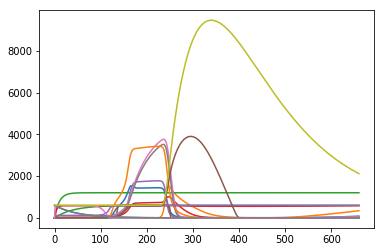

In [8]:
names = ['clb1','clb3','cdc20T','cdc20','clb4','sp','cdc5t','cdc5a','ndd1t','ndd1a','hcm1','ndt80','sum1iIme2','sum1iCdk1','sum1iRC','ama1p','rc','dsb','ama1t']
for j in range(0,19):
    points = []
    for i in range(0, p_t.shape[0]):
        points.append(p_t[i][j])
    plt.plot(time, points)
    #plt.title('Deterministic solution: ' + names[j])
plt.show()

#### Visualize mathematica notebook

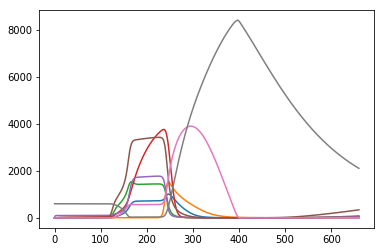

In [9]:
# 3 1 0 6 4 11 15 18-15 
for j in [3,1,0,6,4,11,15]:
    points = []
    for i in range(0, p_t.shape[0]):
        points.append(p_t[i][j])
    plt.plot(time, points)
    #plt.title('Deterministic solution: ' + names[j])
    
# add 18-15 term
points = []
for i in range(0, p_t.shape[0]):
    points.append(p_t[i][18]-p_t[i][15])
plt.plot(time, points)
plt.show()